# 関数定義

In [95]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [96]:
# sstの陸面をマスクする関数
def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    f = ma.filled(z, np.nan) # for masking
    #f = ma.filled(z, 0) # for filing with 0
    return f

In [97]:
# (緯度、経度、時間)の三次元情報を => (空間, 時間)の二次元行列に変換する関数
def latlon_to_X(var):
    # 三次元情報それぞれのshapeを取得
    imt, jmt, tmt = var.shape
    # 出力行列Xのshapeを決定
    X = np.zeros((imt*jmt, tmt))
    
    # 行列に変換
    cc = 0 # 行列Xの空間次元のインデックス
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                X[cc, :] = np.squeeze(var[ii, jj, :])
                cc = cc + 1
    X = np.squeeze(X[0:cc, :]) #squeezeは長さが1の軸が存在する場合に取り除くための保険
    return X

In [98]:
# 二次元行列を三次元に変換する関数
def X_to_latlon(X):
    #　対象とする地域の降水データグリッドサイズが20x20の行列なので、手動でimt,jmtを設定
    imt, jmt = 20, 20
    
    SVDs = np.zeros((imt, jmt))
    
    # 行列を三次元情報に復元
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            SVDs[ii, jj] = X[cc]
            cc += 1
    
    return SVDs

In [120]:
def PQ_to_latlon(P, var):
    # 行列のサイズを得る
    smt, mmt = P.shape
    imt, jmt, kmt = var.shape
    
    # 出力するデータ行列を初期化しておく(この時、最大サイズ(すべて海)を仮定)
    SVDs = np.zeros((imt, jmt, mmt))
    
    # lat-lon行列の作成
    cc = 0 # 何番目のNaNでなはない格子なのかを数えるカウンター
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                SVDs[ii, jj, :] = P[cc, :]
                cc = cc + 1
            else:
                SVDs[ii, jj, :] = np.nan
    return SVDs

In [121]:
from scipy import signal

# 引数は、時系列、　サンプリング間隔(月別だと一か月)、　カットオフ周波数、　フィルタオーダー
def butterworth_lowpass(time_series, delta_t, f_cut, order):
    b, a = signal.butter(order, f_cut, btype='low', fs=1/delta_t) #　フィルタオーダーは1
    time_series_lp = signal.filtfilt(b, a, time_series) # 与えられた時系列に対してフィルターを実行する
    return time_series_lp

In [122]:
# sstを可視化するための関数
def show_sst(image, img_extent):
    projection = ccrs.PlateCarree(central_longitude=180)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection)
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='horizontal')
    plt.show()

In [149]:
# prcpを可視化するための関数
def show_prcp(image):
    projection =ccrs.PlateCarree(central_longitude=180)
    img_extent = (-90, -70, 5, 25) # location=(N5-25, #90-110)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     vmin=-1.5, vmax=1.5) # vminとvmaxは結果を見て見やすいように調整
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='vertical')
    plt.show()

In [166]:
# 特異値ベクトルの任意のモードに射影したときのSSTとPRCPの時系列を可視化する関数
def plot_2_mon_time(time_series1, time_series2, lower=-3, upper=3, init_year=1985, fin_year=2014):
    mon = np.arange(init_year, fin_year+1)
    plt.plot(mon, time_series1)
    plt.plot(mon, time_series2, 'r')
    plt.plot(mon, 0*time_series1, 'k')
    plt.xlim(init_year, fin_year)
    plt.ylim(lower, upper)
    plt.show()

# データの読み込み

In [167]:
# データ保存場所のパスを記述
workdir = '/docker/mnt/d/research/D2/cnn3'
sst_path = workdir + '/predictors/predictors_coarse_std_Apr_o.npy'
prcp_path = workdir + '/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy'

# sstとprcpのshapeを確認
# sstは5x5°解像度を使用
sst = np.squeeze(np.load(sst_path)) # [モデルの種類42, 年(1851-2014)165, 緯度(S60-N60)24, 経度(E0-360)72]
# prcpは1x1°の解像度を使用
prcp = np.load(prcp_path) # [モデルの種類42, 年(1851-2014)165, 緯度(N10-20)20, 経度(E95-110)20]
print(sst.shape, prcp.shape)

(42, 165, 24, 72) (42, 165, 20, 20)


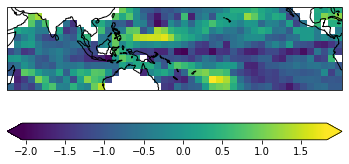

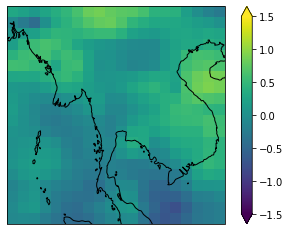

In [168]:
#SSTの中央太平洋とインド洋を抜き出して可視化: E45-W75, S30-N30
img_extent = (-135, 105, -30, 30)
sst_m0_y0 = sst[0, 0, :, :]
prcp_masked = mask(sst_m0_y0)
ocean = prcp_masked[6:18, 9:57]
show_sst(ocean, img_extent)

#PRCPについても可視化: N10-20, E95-110
prcp_m0_y0 = prcp[0, 0, :, :]
show_prcp(prcp_m0_y0)

# 特異値行列の計算

In [169]:
# 今回はモデル番号1(BCC-CSM2-MR)の1984-2014年のデータをもとに特異値行列を計算
training_model_index = 1 # 用いるモデルの番号
training_period = -30 # 用いる年の範囲

# sstとprcp行列を作成
umi = sst[training_model_index, training_period:, 6:18, 9:57] # 太平洋とインド洋の部分を切り出し
umi = umi.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
umi = mask(umi) # 陸域をマスク
X = latlon_to_X(umi) # SSTの行列を作成

ame = prcp[training_model_index, training_period:, :, :]# 降水のデータを切り出し
ame = ame.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
Y = latlon_to_X(ame) # PRCPの行列を作成

print(X.shape, Y.shape)

(470, 30) (400, 30)


In [204]:
# 共分散行列を作成
N = X.shape[1] # 時間方向のshape(30年)
C_XY = X@Y.T/N 

# 特異値分解で左右特異行列P, Qを取得
P, S, QT = np.linalg.svd(C_XY, full_matrices=False)
# 右特異行列を転置
Q = QT.T

# Sigmaの計算
Sigma = np.zeros(C_XY.shape) # Xと同じ
for ss in range(0, S.shape[0]):
    Sigma[ss, ss] = S[ss] # 特異値を対角行列に並べる
    
# P, Qに元の行列を射影することでSVDの時系列の計算
P_star = P.T@X
Q_star = Q.T@Y

# 再現実験

In [171]:
# 特異値分解に用いたモデル番号1(BCC-CSM2-MR)の2014年のデータを再現できるかを確認
validation_model_index = 1 # 用いるモデルの番号
validation_year_index = -1 # 用いる年(2014年)

tmp = sst[validation_model_index, :, 6:18, 9:57] # インド洋と太平洋を切り抜き
tmp = tmp.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
tmp = mask(tmp) # 陸域をマスク
X_val = latlon_to_X(tmp) # sstの行列を作成

# 時間展開係数 Aを計算
sst_input = X_val[:, validation_year_index] # 2014年のsstをインプットとして用意

A = P.T@sst_input # 時間発展係数　=　左特異行列　＊　SST行列

In [172]:
# PRCP行列を緯度経度座標に復元
grids = 20*20 # 雨データのグリッド数(緯度グリッド20 * 経度グリッド20)
prcp_output = np.zeros(grids)
# モード毎にprcpを計算して足し合わせる
for i in range(A.shape[0]):
    mode_i = Q.T[i]*A[i] # PRCPのi番目のモード = 右特異行列 * 時間発展係数B(Bが未知なのでAで代用)
    prcp_output += mode_i # 各モードを足し合わせる
print(prcp_output.shape)

(400,)


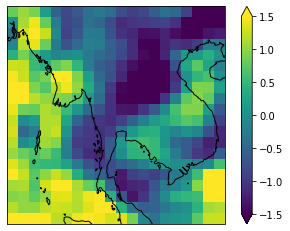

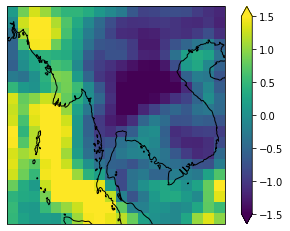

In [173]:
# 可視化
# 合ってないように見えるけれど、それぞれの分散で正規化すると分布はあっている

# 特異値解析で得られた降水量分布
prcp_latlon = X_to_latlon(prcp_output)
latlon_norm = (prcp_latlon-np.mean(prcp_latlon))/np.std(prcp_latlon)
show_prcp(latlon_norm)

# 元データから得られた降水量
prcp_label = prcp[validation_model_index, validation_year_index, :, :]
label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(label_norm)

# SVDの描写

(12, 48, 400)
(12, 48)


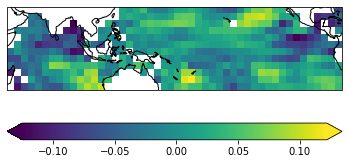

In [202]:
mode_index = 4

sst_SVDs = PQ_to_latlon(P, umi)
svd1_sst_map = sst_SVDs[:, :, mode_index]

img_extent = (-135, 105, -30, 30)
show_sst(svd1_sst_map, img_extent)

# 海面水温が降水の分散の何パーセントを説明しているか確認する

26.531073819549476


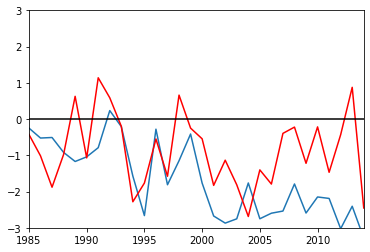

17.68163495511673


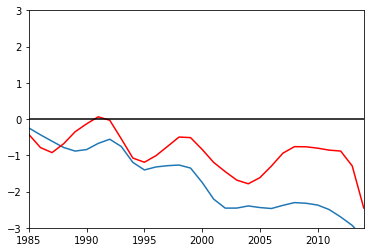

52.764711768047725


In [208]:
mode_index = 0

# 規格化前の時系列の共分散が最大になるように選んだ空間パターンが、描写したSVDモード1
svd1_sst_time = P_star[mode_index,:]
svd1_prcp_time = Q_star[mode_index,:]
#　SVD第一モードは共分散全体のうち何%を説明するか
print(Sigma[mode_index, mode_index]/np.trace(Sigma)*100)

# 正規化した時系列
svd1_sst_time = svd1_sst_time/np.std(svd1_sst_time)
svd1_prcp_time = svd1_prcp_time/np.std(svd1_prcp_time)
plot_2_mon_time(svd1_sst_time, svd1_prcp_time)
#　規格化後のSVD第一モードは、互いの分散を何%説明するか(相関係数の二乗で計算できる)
print((np.corrcoef(svd1_sst_time, svd1_prcp_time)[0, 1])**2*100)

# ローパスフィルターを通した後
svd1_sst_time_low = butterworth_lowpass(svd1_sst_time, 1, 0.12, 1)
svd1_prcp_time_low = butterworth_lowpass(svd1_prcp_time, 1, 0.12, 1)
plot_2_mon_time(svd1_sst_time_low, svd1_prcp_time_low)
#　規格化後のSVD第一モードは、互いの分散を何%説明するか(相関係数の二乗で計算できる)
print((np.corrcoef(svd1_sst_time_low, svd1_prcp_time_low)[0, 1])**2*100)